## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('temp_datalab_records_social_facebook.csv',  low_memory=False)

In [3]:
data.head()

,dataset_id,time,username,checkins,has_added_app,were_here_count,likes,talking_about_count,facebook_id,date_added,date_updated,entity_id,cusip,isin
0,53088,2015-01-01 05:00:00+00,SodaStream,0,f,0,761533,587,54885616308,NaN,2017-02-14 03:35:13.236826+00,NaN,NaN,NaN
1,52642,2015-01-01 05:00:00+00,ANSYSInc,148,f,0,43442,1305,160242297413411,NaN,2017-02-14 01:55:52.78506+00,NaN,NaN,NaN
2,53656,2015-01-01 05:00:00+00,MyAquaAmerica,0,f,0,5591,297,591693544195818,NaN,2017-02-14 08:13:51.267343+00,NaN,NaN,NaN
3,53033,2015-01-01 05:00:00+00,Qualcomm,173,f,0,1232521,2685,108472637291,NaN,2017-02-14 03:24:04.363035+00,NaN,NaN,NaN
4,52783,2015-01-01 05:00:00+00,eaglepharmaceuticals,0,f,0,18,0,1428265940729350,NaN,2017-02-14 02:22:10.193588+00,NaN,NaN,NaN


In [4]:
data.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3621391 entries, 0 to 3621390
Data columns (total 14 columns):
dataset_id             3621391 non-null int64
time                   3621391 non-null object
username               3500462 non-null object
checkins               3621391 non-null int64
has_added_app          3621391 non-null object
were_here_count        3621391 non-null int64
likes                  3621391 non-null int64
talking_about_count    3621391 non-null int64
facebook_id            3621391 non-null int64
date_added             2099106 non-null object
date_updated           3620027 non-null object
entity_id              0 non-null float64
cusip                  0 non-null float64
isin                   0 non-null float64
dtypes: float64(3), int64(6), object(5)
memory usage: 386.8+ MB


In [5]:
data['time'] = pd.to_datetime(data['time'])

In [6]:
#Drop empty & unused columns

data = data.drop(['entity_id','cusip','isin','date_updated','date_added'], axis = 'columns')
data.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3621391 entries, 0 to 3621390
Data columns (total 9 columns):
dataset_id             3621391 non-null int64
time                   3621391 non-null datetime64[ns]
username               3500462 non-null object
checkins               3621391 non-null int64
has_added_app          3621391 non-null object
were_here_count        3621391 non-null int64
likes                  3621391 non-null int64
talking_about_count    3621391 non-null int64
facebook_id            3621391 non-null int64
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 248.7+ MB


In [7]:
#Check unique values in columns

for c in data.columns:
    temp = data[c].drop_duplicates()
    leng = len(temp)
    print(leng,'unique values in column', c)

4714 unique values in column dataset_id
1241 unique values in column time
4951 unique values in column username
117065 unique values in column checkins
1 unique values in column has_added_app
244669 unique values in column were_here_count
926145 unique values in column likes
134589 unique values in column talking_about_count
4714 unique values in column facebook_id


In [8]:
lat_date = data['time'].max()
ear_date = data['time'].min()

print(ear_date,lat_date)

2015-01-01 05:00:00 2018-07-17 04:00:00


In [9]:
lat_date - ear_date

Timedelta('1292 days 23:00:00')

In [10]:
id_name_pair = data[['dataset_id','username']].drop_duplicates()
id_name_pair.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5212 entries, 0 to 3616431
Data columns (total 2 columns):
dataset_id    5212 non-null int64
username      4950 non-null object
dtypes: int64(1), object(1)
memory usage: 122.2+ KB


There are 4714 unique facebook accounts in the data, in which records of 1241 dates are stored, through 2015-1-1 to 2018-07-17. Note that the difference between earliest date and latest date is bigger than unique dates count, which means there are some dates missing during this period.

We see that number of unique usernames is bigger than ids, the reason could be typos or mistakes in the records, or some accounts had changed their usernames during the period. Besides, according the 'id_name_pair', we see that usernames of some accounts are missing. Hence, 'dataset_id' will be used as id in this project.

Besides, all records have the same value in 'has_added_app'. 

## Explore 'Pooled' Data

This is a panel data. It is also not balanced since each id has different days of records. Exploration on the whole pooled data is done first.

In [11]:
#Description statistics for performance metrics

data[['checkins','were_here_count','likes','talking_about_count']].describe()

,checkins,were_here_count,likes,talking_about_count
count,3.621391e+06,3.621391e+06,3.621391e+06,3.621391e+06
mean,1.417013e+04,1.356737e+05,8.166253e+05,1.004266e+04
std,2.326502e+05,1.330491e+06,4.937245e+06,7.292689e+04
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,2.500000e+03,2.700000e+01
50%,1.300000e+01,0.000000e+00,2.047700e+04,2.510000e+02
75%,2.860000e+02,1.140000e+02,2.175790e+05,2.474000e+03
max,1.729055e+07,3.682637e+07,2.106411e+08,5.747010e+06


In [12]:
count_time_pair = data[['time','dataset_id']].drop_duplicates()

count_by_time = count_time_pair.groupby('time')['dataset_id'].aggregate('count').reset_index().sort_values('time')
count_by_time.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1241 entries, 0 to 1240
Data columns (total 2 columns):
time          1241 non-null datetime64[ns]
dataset_id    1241 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 29.1 KB


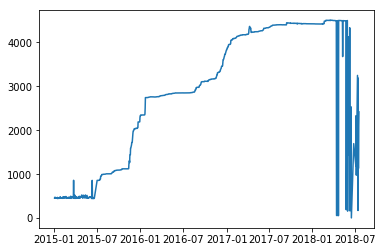

In [15]:
#Look at number of accounts by date

Date = count_by_time['time']
Count_ID = count_by_time['dataset_id']

plt.plot(Date, Count_ID)
plt.show()

All metrics have big ranges. We see that at least 25% of 'checkins' and 50% of 'were_here_count' are zero, while 'likes' does not have zero values. Besides, there is much more large numbers in 'likes' than other 3 metrics. It is because users do not need to really get engaged with a facebook page to hit the like button. Hence, 'likes' is not a good metric to measure the popularity of a facebook page.

It is seen that number of accounts / companies had been increasing since mid 2015. After a platform in 2016, it started rising again until being relatively stable in mid 2017. Note that the numbers in 2018 has very severe fluctuation. The reason could be incomplete records in 2018.

In [16]:
metric_by_time = data.groupby('time')['checkins','were_here_count','likes','talking_about_count'].aggregate('sum').reset_index().sort_values('time')
metric_by_time.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1241 entries, 0 to 1240
Data columns (total 5 columns):
time                   1241 non-null datetime64[ns]
checkins               1241 non-null int64
were_here_count        1241 non-null int64
likes                  1241 non-null int64
talking_about_count    1241 non-null int64
dtypes: datetime64[ns](1), int64(4)
memory usage: 58.2 KB


In [17]:
#Create 2 metrics, engaging ratio and conversion ratio

metric_by_time['engaging'] = metric_by_time['talking_about_count'] / metric_by_time['likes']

metric_by_time['conversion'] = metric_by_time['checkins'] / metric_by_time['talking_about_count']

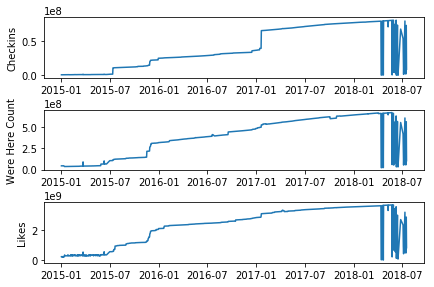

In [18]:
#Look at overall changes of metrics over time

x = metric_by_time['time']

y1 = metric_by_time['checkins']
y2 = metric_by_time['were_here_count']
y3 = metric_by_time['likes']
y4 = metric_by_time['talking_about_count']
y5 = metric_by_time['engaging']
y6 = metric_by_time['conversion']

fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.plot(x, y1)
plt.ylabel('Checkins')

plt.subplot(3, 1, 2)
plt.plot(x, y2)
plt.ylabel('Were Here Count')

plt.subplot(3, 1, 3)
plt.plot(x, y3)
plt.ylabel('Likes')

plt.show()

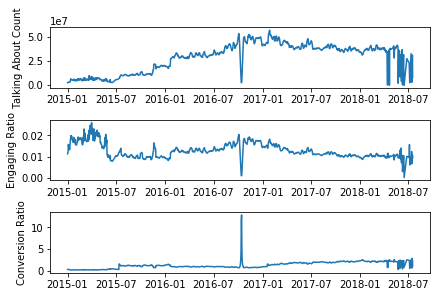

In [19]:
fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.plot(x, y4)
plt.ylabel('Talking About Count')

plt.subplot(3, 1, 2)
plt.plot(x, y5)
plt.ylabel('Engaging Ratio')

plt.subplot(3, 1, 3)
plt.plot(x, y6)
plt.ylabel('Conversion Ratio')

plt.show()

We see that Checkins, Were Here Count, and Likes almost followed the same trend as number of accounts during the time period, while total Talking About Count has fell a little bit since 2017. Engaging ratio followed the trend of Talking About Count but extent of change is not as obvious as Talking About Count, except for early 2015.

Conversion Ratio kept stationary in most of the time, except for a extremely high value in 2016.The overall conversion level after 2017 was higher than before 2017. Note that conversion ratio was also above 1 at most time.

In [20]:
#Correlation between metrics

data[['checkins','were_here_count','likes','talking_about_count']].corr()

,checkins,were_here_count,likes,talking_about_count
checkins,1.000000,0.166944,0.052411,0.038259
were_here_count,0.166944,1.000000,0.256956,0.065495
likes,0.052411,0.256956,1.000000,0.358866
talking_about_count,0.038259,0.065495,0.358866,1.000000


No metrics are highly correlated. Likes is moderately correlated with Were Here Count and Talking About Count.

## Explore Data Grouped by ID

In [21]:
#Preparation before grouping

data_temp = data[['dataset_id','time','checkins','were_here_count','likes','talking_about_count']].drop_duplicates()

data_temp['date_count'] = data_temp['time']
data_temp['date_earl']  = data_temp['time']
data_temp['date_late']  = data_temp['time']

data_temp['chechin_mean'] = data_temp['checkins']
data_temp['chechin_sum']  = data_temp['checkins']

data_temp['werehere_mean'] = data_temp['were_here_count']
data_temp['werehere_sum']  = data_temp['were_here_count']

data_temp['likes_mean'] = data_temp['likes']
data_temp['likes_sum']  = data_temp['likes']

data_temp['talking_mean'] = data_temp['talking_about_count']
data_temp['talking_sum']  = data_temp['talking_about_count']

data_temp['engaging_min']  = data_temp['talking_about_count'] / data_temp['likes']
data_temp['engaging_max']  = data_temp['talking_about_count'] / data_temp['likes']

data_temp['conversion_min']  = data_temp['checkins'] / data_temp['talking_about_count']
data_temp['conversion_max']  = data_temp['checkins'] / data_temp['talking_about_count']

data_temp.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3621391 entries, 0 to 3621390
Data columns (total 21 columns):
dataset_id             3621391 non-null int64
time                   3621391 non-null datetime64[ns]
checkins               3621391 non-null int64
were_here_count        3621391 non-null int64
likes                  3621391 non-null int64
talking_about_count    3621391 non-null int64
date_count             3621391 non-null datetime64[ns]
date_earl              3621391 non-null datetime64[ns]
date_late              3621391 non-null datetime64[ns]
chechin_mean           3621391 non-null int64
chechin_sum            3621391 non-null int64
werehere_mean          3621391 non-null int64
werehere_sum           3621391 non-null int64
likes_mean             3621391 non-null int64
likes_sum              3621391 non-null int64
talking_mean           3621391 non-null int64
talking_sum            3621391 non-null int64
engaging_min           3621391 non-null float64
engaging_max         

In [22]:
#Replace infinity & null values with 0

data_temp = data_temp.replace([np.inf, -np.inf], np.nan)
data_temp = data_temp.fillna(0)
data_temp.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3621391 entries, 0 to 3621390
Data columns (total 21 columns):
dataset_id             3621391 non-null int64
time                   3621391 non-null datetime64[ns]
checkins               3621391 non-null int64
were_here_count        3621391 non-null int64
likes                  3621391 non-null int64
talking_about_count    3621391 non-null int64
date_count             3621391 non-null datetime64[ns]
date_earl              3621391 non-null datetime64[ns]
date_late              3621391 non-null datetime64[ns]
chechin_mean           3621391 non-null int64
chechin_sum            3621391 non-null int64
werehere_mean          3621391 non-null int64
werehere_sum           3621391 non-null int64
likes_mean             3621391 non-null int64
likes_sum              3621391 non-null int64
talking_mean           3621391 non-null int64
talking_sum            3621391 non-null int64
engaging_min           3621391 non-null float64
engaging_max         

In [23]:
#Group data

data_group = data_temp.groupby('dataset_id').agg({'date_count': lambda x: len(x), 'date_earl':lambda x: x.min(), 
                                    'date_late':lambda x: x.max(), 
                                    'chechin_mean': lambda x: x.mean(), 'chechin_sum': lambda x: x.sum(), 
                                    'werehere_mean': lambda x: x.mean(), 'werehere_sum': lambda x: x.sum(),
                                    'likes_mean': lambda x: x.mean(), 'likes_sum': lambda x: x.sum(),
                                    'talking_mean': lambda x: x.mean(), 'talking_sum': lambda x: x.sum(),
                                    'engaging_min':lambda x: x.min(), 'engaging_max':lambda x: x.max(), 
                                    'conversion_min':lambda x: x.min(), 'conversion_max':lambda x: x.max()})

data_group.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4714 entries, 52612 to 2340089
Data columns (total 15 columns):
date_count        4714 non-null int64
date_earl         4714 non-null datetime64[ns]
date_late         4714 non-null datetime64[ns]
chechin_mean      4714 non-null float64
chechin_sum       4714 non-null int64
werehere_mean     4714 non-null float64
werehere_sum      4714 non-null int64
likes_mean        4714 non-null float64
likes_sum         4714 non-null int64
talking_mean      4714 non-null float64
talking_sum       4714 non-null int64
engaging_min      4714 non-null float64
engaging_max      4714 non-null float64
conversion_min    4714 non-null float64
conversion_max    4714 non-null float64
dtypes: datetime64[ns](2), float64(8), int64(5)
memory usage: 589.2 KB


In [24]:
data_group.head()

,date_count,date_earl,date_late,chechin_mean,chechin_sum,werehere_mean,werehere_sum,likes_mean,likes_sum,talking_mean,talking_sum,engaging_min,engaging_max,conversion_min,conversion_max
dataset_id,,,,,,,,,,,,,,,
52612,1220,2015-01-01 05:00:00,2018-07-16 04:00:00,13843.294262,16888819,1.492335e+07,18206487941,3.322463e+07,40534054108,125494.788525,153103642,0.000181,0.023209,0.01754,2.338195
52615,1064,2015-03-23 04:00:00,2018-07-17 04:00:00,82.455827,87733,8.245583e+01,87733,1.743741e+02,185534,5.400376,5746,0.000000,0.829897,0.00000,143.000000
52619,1198,2015-01-01 05:00:00,2018-07-17 04:00:00,0.000000,0,0.000000e+00,0,2.020841e+03,2420967,54.393155,65163,0.001425,0.161290,0.00000,0.000000
52620,1066,2015-03-23 04:00:00,2018-07-16 04:00:00,8.254221,8799,8.254221e+00,8799,6.973009e+03,7433228,89.424953,95327,0.000459,0.260901,0.00000,1.727273
52621,1094,2015-01-01 05:00:00,2018-07-17 04:00:00,487.231261,533031,0.000000e+00,0,5.495279e+04,60118353,3250.062157,3555568,0.000000,0.653359,0.00000,8.628571


In [25]:
data_group['engaging_overall']   = data_group['talking_sum'] / data_group['likes_sum']
data_group['conversion_overall'] = data_group['chechin_sum'] / data_group['talking_sum']

data_group[['engaging_overall','conversion_overall']].info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4714 entries, 52612 to 2340089
Data columns (total 2 columns):
engaging_overall      4714 non-null float64
conversion_overall    4711 non-null float64
dtypes: float64(2)
memory usage: 110.5 KB


In [26]:
data_group = data_group.replace([np.inf, -np.inf], np.nan)
data_group = data_group.fillna(0)
data_group.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4714 entries, 52612 to 2340089
Data columns (total 17 columns):
date_count            4714 non-null int64
date_earl             4714 non-null datetime64[ns]
date_late             4714 non-null datetime64[ns]
chechin_mean          4714 non-null float64
chechin_sum           4714 non-null int64
werehere_mean         4714 non-null float64
werehere_sum          4714 non-null int64
likes_mean            4714 non-null float64
likes_sum             4714 non-null int64
talking_mean          4714 non-null float64
talking_sum           4714 non-null int64
engaging_min          4714 non-null float64
engaging_max          4714 non-null float64
conversion_min        4714 non-null float64
conversion_max        4714 non-null float64
engaging_overall      4714 non-null float64
conversion_overall    4714 non-null float64
dtypes: datetime64[ns](2), float64(10), int64(5)
memory usage: 662.9 KB


In [27]:
#Correlation in grouped data

data_group[['chechin_mean','werehere_mean','likes_mean','talking_mean','engaging_overall','conversion_overall']].corr()

,chechin_mean,werehere_mean,likes_mean,talking_mean,engaging_overall,conversion_overall
chechin_mean,1.000000,0.217130,0.072933,0.059246,-0.014176,0.153257
werehere_mean,0.217130,1.000000,0.277616,0.089774,-0.041497,0.013598
likes_mean,0.072933,0.277616,1.000000,0.409120,-0.067046,-0.029492
talking_mean,0.059246,0.089774,0.409120,1.000000,0.146013,-0.028931
engaging_overall,-0.014176,-0.041497,-0.067046,0.146013,1.000000,-0.064352
conversion_overall,0.153257,0.013598,-0.029492,-0.028931,-0.064352,1.000000


Similar to the case in pooled data, no metrics are highly correlated. Note that Engaging is negativley related to Checkin, Werehere, and Likes, Conversion is negatively correlated to Likes and Talking, and the 2 ratioes are negatively correlated to each other. However, other pairs of metrics are all positively related.

This may implies increasing Likes, which indicates exposure, and Talking, which indicates popularity, has effects on improving page popularity and foot traffic, which is indicated by Chechin, respectively. However, due to diminishing marginal effects, the 2 ratioes are negatively related to their denominators.

Note that correlation between Likes and Talking is about 0.4, while that between Checkin and Talking is only 0.06, which might imply it much harder to convert populartiy to foot traffic than exposure to popularity.

In [28]:
data_group.describe()

,date_count,chechin_mean,chechin_sum,werehere_mean,werehere_sum,likes_mean,likes_sum,talking_mean,talking_sum,engaging_min,engaging_max,conversion_min,conversion_max,engaging_overall,conversion_overall
count,4714.000000,4.714000e+03,4.714000e+03,4.714000e+03,4.714000e+03,4.714000e+03,4.714000e+03,4.714000e+03,4.714000e+03,4714.000000,4714.000000,4714.000000,4714.000000,4714.000000,4714.000000
mean,768.220407,1.481257e+04,1.088578e+07,1.133437e+05,1.042273e+08,7.122836e+05,6.273482e+08,8.823142e+03,7.714977e+06,0.001969,0.424417,0.912913,124.621257,0.035883,6.754659
std,286.361000,2.737647e+05,1.560556e+08,1.212108e+06,1.112789e+09,4.392324e+06,4.318134e+09,5.439167e+04,5.328930e+07,0.006090,1.552297,8.204496,1343.760700,0.056843,28.466268
min,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.772370e+00,3.520000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,533.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.022574e+03,1.317253e+06,3.660873e+01,2.356775e+04,0.000000,0.045172,0.000000,0.000000,0.006781,0.000000
50%,862.000000,1.400000e+01,8.870000e+03,0.000000e+00,0.000000e+00,1.595739e+04,1.156189e+07,3.061167e+02,2.224375e+05,0.000382,0.131969,0.000000,1.000000,0.017137,0.045579
75%,927.000000,2.502290e+02,1.722035e+05,1.542064e+02,9.542475e+04,1.780939e+05,1.385446e+08,2.804816e+03,2.235460e+06,0.001443,0.360295,0.029564,30.325487,0.038462,1.816312
max,1222.000000,1.590118e+07,7.966491e+09,3.435565e+07,2.803729e+10,1.832226e+08,1.912844e+11,1.641433e+06,1.992700e+09,0.112302,43.299312,416.640351,78308.000000,1.057286,947.454622


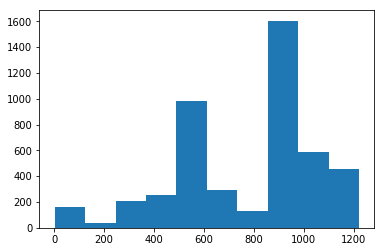

In [29]:
#Distribution of days on record

plt.hist(data_group['date_count'])
plt.show()

Almost half of accounts / companies had been on record over 800 days, almost 75% over 500 days.

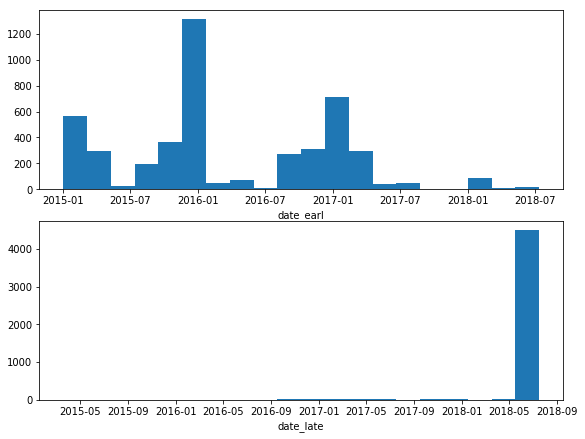

In [30]:
#Histogram for start & end date of records

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(8,6))
fig.tight_layout()

plt.subplot(2,1,1)
plt.hist(data_group['date_earl'],20)
plt.xlabel('date_earl')

plt.subplot(2,1,2)
plt.hist(data_group['date_late'],20)
plt.xlabel('date_late')

plt.show()

The periods when most companies started to have the records are 2015 season 1 & 2, end of 2015 to beginning of 2016, and 2016 Q3 to 2017 Q2. The 3 periods are all around the end or beginning of a year. However, there were not many companies joining into the record in 2018.

Almost all compnaies were kept being recorded until June & July 2018. Note that the latest date in record is 2018-7-17.

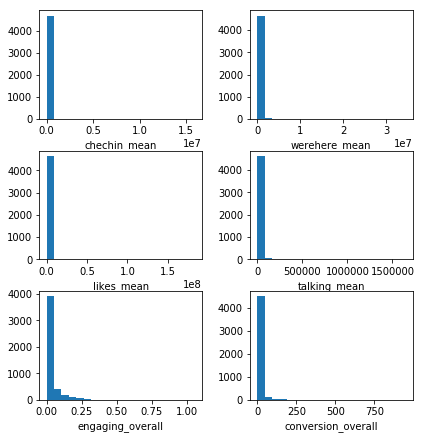

In [31]:
#Histogram for 6 metrics

fig, axes = plt.subplots(3,2,figsize=(6,6))
fig.tight_layout()

plt.subplot(3,2,1)
plt.hist(data_group['chechin_mean'],20)
plt.xlabel('chechin_mean')

plt.subplot(3,2,2)
plt.hist(data_group['werehere_mean'],20)
plt.xlabel('werehere_mean')

plt.subplot(3,2,3)
plt.hist(data_group['likes_mean'],20)
plt.xlabel('likes_mean')

plt.subplot(3,2,4)
plt.hist(data_group['talking_mean'],20)
plt.xlabel('talking_mean')

plt.subplot(3,2,5)
plt.hist(data_group['engaging_overall'],20)
plt.xlabel('engaging_overall')

plt.subplot(3,2,6)
plt.hist(data_group['conversion_overall'],20)
plt.xlabel('conversion_overall')

plt.show()

We see that all 6 metrics are very skewed. Mectric values of most observations are concentrated with a relatively small range, while a few observations have extremely large numbers. Similar to the case of pooled data, Checkin and Werehere tend to have smaller scale of value than Talking and Likes, among which Likes tends to have largest scale. 

The majority of campanies have Engaging & Conversion Ratios smaller than 1. Ratios of some accounts are above 1. Note that the proportion of over-one Conversion is much higher than over-one Engaging ratio. My understanding is that foot traffic is not completely dependent on social media behavior, so that for some companies with channels other than social media, it could be normal that not all people who checked into the account have necessarily got engaged or interacted with their facebook page.

On the hand, since the data is skewed and with very large and different scales, it might be helpful to normalize them before running any models.

In [32]:
#Export grouped data and make plots in excel

#data_group.to_csv('Facebook_Grouped.csv',index=True)